In [1]:
#GWpy- a python package for gravitational astrophysics
import gwpy
print(gwpy.__version__)

2.1.4


+ We can use the `TimeSeries.fetch_open_data` method to download data directly from https://www.gw-openscience.org, but we need to know the GPS times.

In [2]:
from gwosc.datasets import event_gps
gps = event_gps('GW190412')
print(gps)

1239082262.1


In [3]:
segment = (int(gps)-5, int(gps)+5)
print(segment)

(1239082257, 1239082267)


'G1' - GEO600  
'H1' - LIGO-Hanford  
'L1' - LIGO-Livingston  
'V1' - (Advanced) Virgo  
'K1' - KAGRA

In [4]:
from gwpy.timeseries import TimeSeries
ldata = TimeSeries.fetch_open_data('L1', *segment, verbose=True)
print(ldata)

Fetched 1 URLs from www.gw-openscience.org for [1239082257 .. 1239082267))
Reading data... [Done]
TimeSeries([-8.42597565e-19, -8.52437103e-19, -8.60738804e-19,
            ...,  1.38850270e-19,  1.37760541e-19,
             1.38094202e-19]
           unit: dimensionless,
           t0: 1239082257.0 s,
           dt: 0.000244140625 s,
           name: Strain,
           channel: None)


* The `verbose=True` flag lets us see that GWpy has discovered one file that provides the data for the given interval, downloaded it, and loaded the data.  
* The files are not stored permanently, use `cache=True` to store the file on your computer.  
* To read data from a local file instead of from the GWOSC server, we can use TimeSeries.read method.

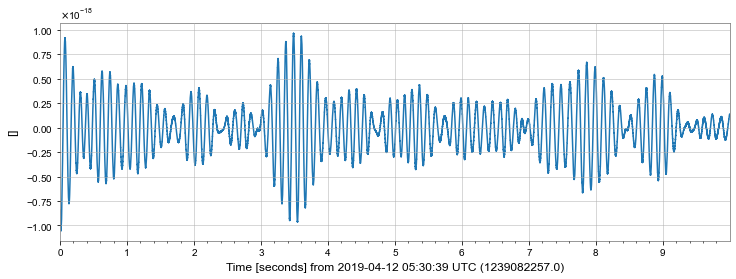

In [7]:
%matplotlib inline
plot = ldata.plot()

There are alternative ways to access the GWOSC data.
+ `readligo` is a light-weight Python module that returns the time series into a Numpy array.
+ The `PyCBC` package has the `pycbc.frame.query_and_read_frame` and `pycbc.frame.read_frame` methods.

In [8]:
#calculate the Fourier transform of our TimeSeries using the fft() method:
fft = ldata.fft()
print(fft)

FrequencySeries([-1.45894410e-21+0.00000000e+00j,
                 -2.91834926e-21-4.52905657e-23j,
                 -2.91973330e-21-9.06202944e-23j, ...,
                 -2.38723982e-23+4.67871178e-26j,
                 -2.38345362e-23+1.80394058e-26j,
                 -2.38457175e-23+0.00000000e+00j]
                unit: dimensionless,
                f0: 0.0 Hz,
                df: 0.1 Hz,
                epoch: 1239082257.0,
                name: Strain,
                channel: None)


C:\Users\USER\anaconda3\lib\site-packages\gwpy\plot\plot.py:279: UserWarning: Matplotlib is currently using module://ipykernel.pylab.backend_inline, which is a non-GUI backend, so cannot show the figure.
  super().show(warn=warn)


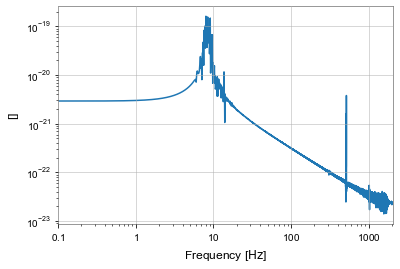

In [9]:
#The result is a FrequencySeries, with complex amplitude, representing the amplitude and phase of each frequency in our data.
#use abs() to extract the amplitude and plot it:

plot = fft.abs().plot(xscale="log", yscale="log")
plot.show(warn=False)

In [10]:
#The problem is that the FFT works under the assumption that our data are periodic.
#We need to apply a window function to our time-domain data before transforming, which we can do using the scipy.signal module:

from scipy.signal import get_window
window = get_window('hann', ldata.size)
lwin = ldata * window

C:\Users\USER\anaconda3\lib\site-packages\gwpy\plot\plot.py:279: UserWarning: Matplotlib is currently using module://ipykernel.pylab.backend_inline, which is a non-GUI backend, so cannot show the figure.
  super().show(warn=warn)


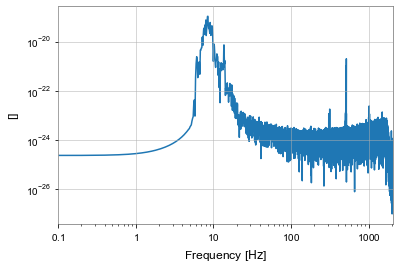

In [11]:
fftamp = lwin.fft().abs()
plot = fftamp.plot(xscale="log", yscale="log")
plot.show(warn=False)

C:\Users\USER\anaconda3\lib\site-packages\gwpy\plot\plot.py:279: UserWarning: Matplotlib is currently using module://ipykernel.pylab.backend_inline, which is a non-GUI backend, so cannot show the figure.
  super().show(warn=warn)


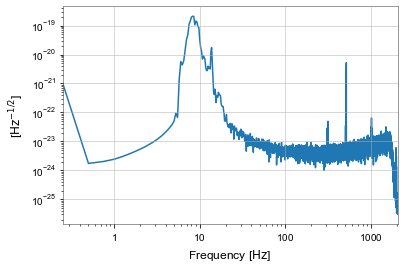

In [12]:
#use a large number of FFTs to estimate an average power spectral density (PSD) -also known as Auto Spectral Density or ASD- over a long period of data.
#We can do this using the asd() method, which uses Welch's method to combine FFTs of overlapping, windowed chunks of data.

asd = ldata.asd(fftlength=4, method="median")
plot = asd.plot()
plot.show(warn=False)

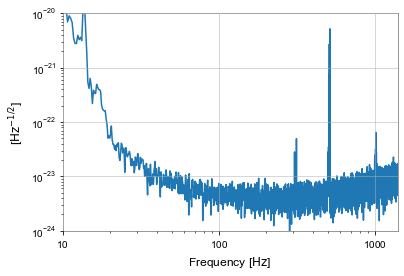

In [13]:
ax = plot.gca()
ax.set_xlim(10, 1400)
ax.set_ylim(1e-24, 1e-20)
plot

In [14]:
#The ASD is a standard tool used to study the frequency-domain sensitivity of a gravitational-wave detector.
#Loading more data allows for more FFTs to be averaged during the ASD calculation, meaning random variations get averaged out, and we can see more detail:

C:\Users\USER\anaconda3\lib\site-packages\gwpy\plot\plot.py:279: UserWarning: Matplotlib is currently using module://ipykernel.pylab.backend_inline, which is a non-GUI backend, so cannot show the figure.
  super().show(warn=warn)


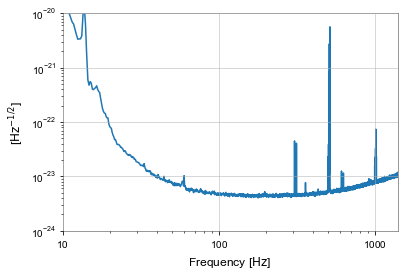

In [15]:
ldata2 = TimeSeries.fetch_open_data('L1', int(gps)-512, int(gps)+512, cache=True)
lasd2 = ldata2.asd(fftlength=4, method="median")
plot = lasd2.plot()
ax = plot.gca()
ax.set_xlim(10, 1400)
ax.set_ylim(1e-24, 1e-20)
plot.show(warn=False)

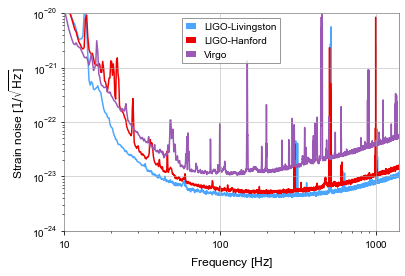

In [16]:
# get Hanford data
hdata2 = TimeSeries.fetch_open_data('H1', int(gps)-512, int(gps)+512, cache=True)
hasd2 = hdata2.asd(fftlength=4, method="median")

# get Virgo data
vdata2 = TimeSeries.fetch_open_data('V1', int(gps)-512, int(gps)+512, cache=True)
vasd2 = vdata2.asd(fftlength=4, method="median")

# and plot using standard colours
ax.plot(hasd2, label='LIGO-Hanford', color='gwpy:ligo-hanford')
ax.plot(vasd2, label='Virgo', color='gwpy:virgo')

# update the Livingston line to use standard colour, and have a label
lline = ax.lines[0]
lline.set_color('gwpy:ligo-livingston')  # change colour of Livingston data
lline.set_label('LIGO-Livingston')

ax.set_ylabel(r'Strain noise [$1/\sqrt{\mathrm{Hz}}$]')
ax.legend()
plot

### Quiz Question 1:
The peak amplitude in the LIGO-Livingston data occurs at approximately 5 seconds into the plot above and is undetectable above the background noise by the eye. Plot the data for the LIGO-Hanford detector around GW190412. Looking at your new LIGO-Handford plot, can your eye identify a signal peak?

Fetched 1 URLs from www.gw-openscience.org for [1239082257 .. 1239082267))
Reading data... [Done]


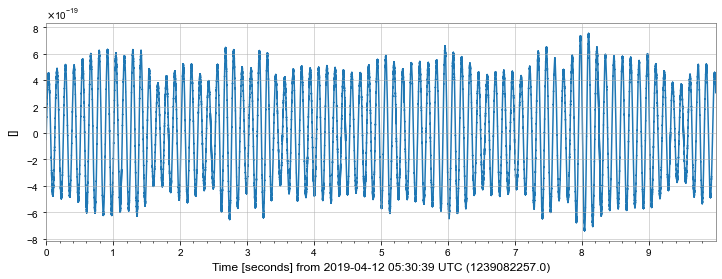

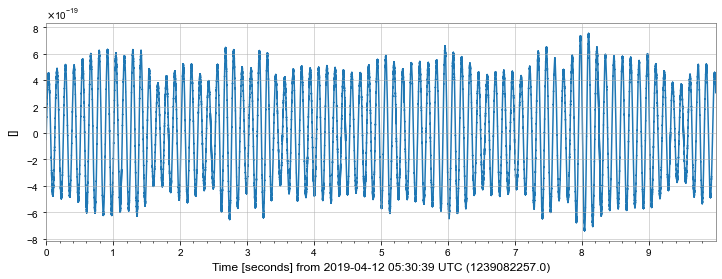

In [20]:
from gwpy.timeseries import TimeSeries
from gwosc.datasets import event_gps

gps = event_gps('GW190412')
segment = (int(gps)-5, int(gps)+5)
hdata = TimeSeries.fetch_open_data('H1', *segment, verbose=True)
hdata.plot()

### Quiz Question 2 :
Make an ASD around the time of an O1 event, GW150914 for L1 detector.  Compare this with the ASDs around GW190412 for L1 detector.  Which data have lower noise - and so are more sensitive - around 100 Hz?

C:\Users\USER\anaconda3\lib\site-packages\gwpy\plot\plot.py:279: UserWarning: Matplotlib is currently using module://ipykernel.pylab.backend_inline, which is a non-GUI backend, so cannot show the figure.
  super().show(warn=warn)


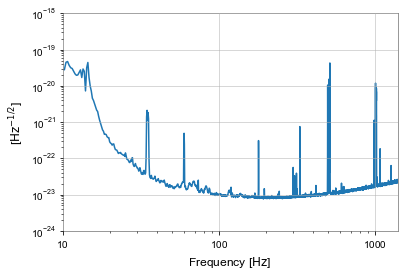

In [50]:
#GW150914
from gwosc.datasets import event_gps
gps1 = event_gps('GW150914')

from gwpy.timeseries import TimeSeries
ldata1 = TimeSeries.fetch_open_data('L1', int(gps1)-512, int(gps1)+512, cache=True)
lasd1 = ldata1.asd(fftlength=4, method="median")
plot1 = lasd1.plot()
ax1 = plot1.gca()
ax1.set_xlim(10,1400)
ax1.set_ylim(1e-24, 1e-18)
plot1.show(warn=False)

C:\Users\USER\anaconda3\lib\site-packages\gwpy\plot\plot.py:279: UserWarning: Matplotlib is currently using module://ipykernel.pylab.backend_inline, which is a non-GUI backend, so cannot show the figure.
  super().show(warn=warn)


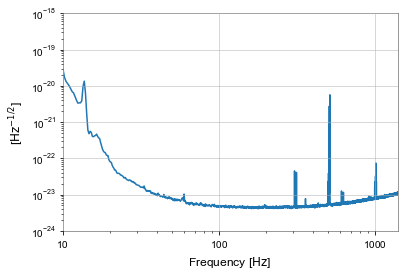

In [51]:
#GW190412
from gwosc.datasets import event_gps
gps2 = event_gps('GW190412')

from gwpy.timeseries import TimeSeries
ldata2 = TimeSeries.fetch_open_data('L1', int(gps2)-512, int(gps2)+512, cache=True)
lasd2 = ldata2.asd(fftlength=4, method="median")
plot2 = lasd2.plot()
ax2 = plot2.gca()
ax2.set_xlim(10,1400)
ax2.set_ylim(1e-24, 1e-18)
plot2.show(warn=False)

(1e-24, 1e-18)

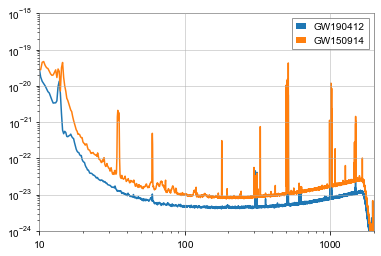

In [52]:
from gwpy.timeseries import TimeSeries
from gwosc.datasets import event_gps
import pylab as plt

gps = event_gps('GW190412')
ldata = TimeSeries.fetch_open_data('L1', int(gps)-512, int(gps)+512, cache=True)
lasd = ldata.asd(fftlength=4, method="median")

gps2 = event_gps('GW150914')
ldata2 = TimeSeries.fetch_open_data('L1', int(gps2)-512, int(gps2)+512, cache=True)
lasd2 = ldata2.asd(fftlength=4, method="median")

plt.loglog(lasd, label = 'GW190412')
plt.loglog(lasd2,label = 'GW150914')
plt.legend()
plt.xlim(10,2000)
plt.ylim(1e-24,1e-18)